# 1. Import Libraries Needed
---

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud
from pprint import pprint

import string
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)
%matplotlib inline

# 2. Read the Dataset
---

In [2]:
df = pd.read_csv('data/data_preprocessed.csv')

In [3]:
df.sample(5)

,tweet_id,created_at,author_id,username,text,reference_type,text_cleaned
4972,1613831118016647170,2023-01-13T09:31:36.000Z,55507370,tvOneNews,"2024 Baterai Mobil Listrik Mulai Produksi, Bahlil Optimis Indonesia dapat Bangun Ekosistem https://t.co/AfGqh4M8CA",NaN,"2024 Baterai Mobil Listrik Mulai Produksi, Bahlil Optimis Indonesia dapat Bangun Ekosistem"
6438,1611212356599828480,2023-01-06T04:05:35.000Z,1534819411940429825,indowfofficial,"(12) Selain itu, pemerintah berdalih bantuan terhadap industri kendaraan listrik ini bertujuan untuk mengurangi emisi Gas Rumah Kaca serta mendorong pencapaian target Net-Zero Emission pada 2060 atau lebih cepat. \n\n""Akselerasi penggunaan EV kini semakin krusial,",['replied_to'],"(12) Selain itu, pemerintah berdalih bantuan terhadap industri kendaraan listrik ini bertujuan untuk mengurangi emisi Gas Rumah Kaca serta mendorong pencapaian target Net-Zero Emission pada 2060 atau lebih cepat. ""Akselerasi penggunaan EV kini semakin krusial,"
31906,1646139486735314944,2023-04-12T13:13:32.000Z,874558344593195008,validnewsid,"Pengamat menilai dalam penciptaan pasar kendaraan listrik, pemerintah harus mewaspadai jangan sampai pasar dalam negeri dikuasai oleh produk impor perusahaan asing. https://t.co/Judr5Kdziu",NaN,"Pengamat menilai dalam penciptaan pasar kendaraan listrik, pemerintah harus mewaspadai jangan sampai pasar dalam negeri dikuasai oleh produk impor perusahaan asing."
3285,1616304049233723393,2023-01-20T05:18:09.000Z,1114918612060360704,ayyuaspita19,"@ardianpancaa Baru semalem fyp mas2 ngejelasin kalo mobil listrik indo sama di negara mana gituu, itu beda. Di indo sama aja menyebabkan polusi. Intinya gitu selebihnya w gapaham😭🙌🏻",['replied_to'],"Baru semalem fyp mas2 ngejelasin kalau mobil listrik indonesia sama di negara mana gituu, itu beda. Di indonesia sama saja menyebabkan polusi. Intinya begitu selebihnya saya gapaham😭🙌🏻"
11714,1625510373318336514,2023-02-14T15:00:48.000Z,826275935750021123,WooGyng,"Bright: sebenarnya aku tau apa yang dia suka, tapi itu agak mustahil.. Soalnya dia suka main sama mobil sport 😩 jadi mungkin aku bakal nyoba nyari yang serupa, mungkin mobil listrik kecil yang bisa dia kendarai di lingkungan rumahnya. \n\n😭😭😭\n\n#ไบร์ทวิน #bbrightvc #winmetawin https://t.co/kectpwNN1j https://t.co/JFcWaFiobX",['quoted'],"Bright: sebenarnya saya tahu apa yang dia suka, tapi itu agak mustahil.. Soalnya dia suka main sama mobil sport 😩 jadi mungkin saya bakal mencoba mencari yang serupa, mungkin mobil listrik kecil yang bisa dia kendarai di lingkungan rumahnya. 😭😭😭 ์ทวิน"


In [5]:
df.shape

(41997, 7)

In [4]:
original_tweet = df.text.values.tolist()
cleaned_tweet = df.text_cleaned.values.tolist()

In [5]:
df['created_at'] = df['created_at'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f%z').strftime('%d-%m-%Y'))
df['reference_type'] = df['reference_type'].fillna("['original']")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41997 entries, 0 to 41996
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        41997 non-null  int64 
 1   created_at      41997 non-null  object
 2   author_id       41997 non-null  int64 
 3   username        41997 non-null  object
 4   text            41997 non-null  object
 5   reference_type  41997 non-null  object
 6   text_cleaned    41997 non-null  object
dtypes: int64(2), object(5)
memory usage: 2.2+ MB


In [9]:
df.isna().sum()

tweet_id          0
created_at        0
author_id         0
username          0
text              0
reference_type    0
text_cleaned      0
dtype: int64

# 3. Tokenization
---

In [6]:
df['tokenized'] = df['text_cleaned'].apply(lambda x: word_tokenize(x))

# 4. Exploratory Data Analysis
---

## 4.1. Account Analysis

In [11]:
# Amount of users
df['author_id'].nunique()

15131

In [7]:
# Top Accounts
top_accounts = pd.DataFrame(df.groupby(['author_id','username'])['author_id'].count().sort_values(ascending=False).reset_index(name='count'))

In [13]:
fig = px.bar(top_accounts[:50], x='username', y='count', text_auto=True, title="Top 50 User Accounts",color_discrete_sequence=['#174876'])
fig.update_traces(textfont_size=12, textangle=0, textposition="inside", cliponaxis=False)
fig.show()

As we can see, there are a lot of tweets coming from news media accounts. Therefore, we want to exclude all the tweets from these top 50 accounts.

### 4.1.1. Delete Tweets from News Media Accounts

In [8]:
news_accounts = list(top_accounts['username'][:50])
non_newsAccounts = {'monoieur','PianJuxx77','aliefwikarta','VionaVolandaPls','laagerhei96332','fang_siew','son_hyung_kil','plwhemvvzhihny'} #keep the non news accounts
news_accounts = [uname for uname in news_accounts if uname not in non_newsAccounts]

In [9]:
print('Total Accounts Removed:',len(news_accounts),'acounts')

Total Accounts Removed: 42 acounts


In [10]:
df_filtered1 = df[~df['username'].isin(news_accounts)]

In [11]:
print('Total tweets after excluding the news media accounts:',df_filtered1.shape[0],'tweets')

Total tweets after excluding the news media accounts: 35344 tweets


## 4.2. Term Frequency Analysis

In [12]:
words = df_filtered1['tokenized']
list_of_words = []
for wordlist in words:
    list_of_words += wordlist
    
new_list_of_words = [''.join(char for char in item
                        if char not in string.punctuation)
                    for item in list_of_words if item != '']

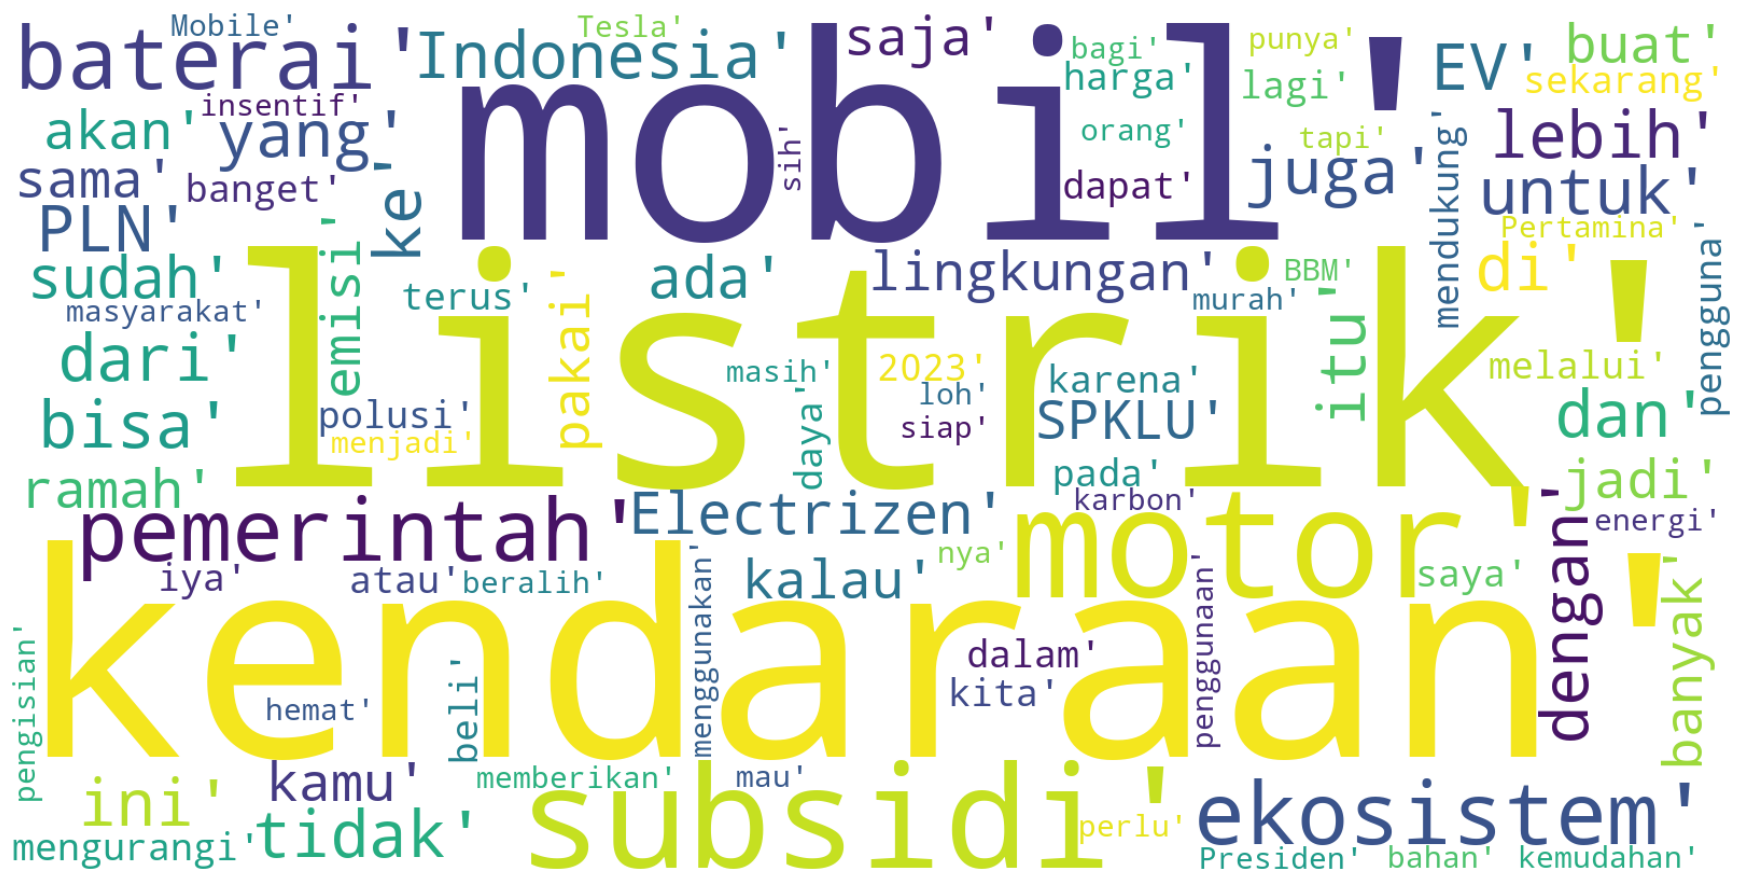

In [19]:
mostcommon = FreqDist(new_list_of_words).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
#plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=5)
plt.show()

## 4.3. Word Count Distribution

In [13]:
df_filtered1['tweet_word_count'] = df_filtered1['text'].astype('str').str.count(' ')

print(df_filtered1.tweet_word_count.describe())

count    35344.000000
mean        22.076873
std         10.187049
min          0.000000
25%         14.000000
50%         21.000000
75%         29.000000
max        143.000000
Name: tweet_word_count, dtype: float64


In [14]:
# word count distribution
N = 5
print('{} documents in total'.format(df_filtered1.shape[0]))
print('{} documents have fewer than {N} words'.format(df_filtered1[df_filtered1.tweet_word_count<=N].shape[0], N = N+1))
print('{}% documents have fewer than {N} words'.format(round(df_filtered1[df_filtered1.tweet_word_count<=N].shape[0]/df_filtered1.shape[0]*100, 1), N = N+1))

fig = px.histogram(df_filtered1, x="tweet_word_count", title="Tweets Word Count Distribution",color_discrete_sequence=['#174876'])
fig.show()

35344 documents in total
509 documents have fewer than 6 words
1.4% documents have fewer than 6 words


We want to delete the tweets that have fewer than 6 words.

In [15]:
df_filtered2 = df_filtered1[df_filtered1['tweet_word_count'] > 5]

In [17]:
df_filtered2.shape

(34835, 9)

In [18]:
# Save the filtered dataset
df_filtered2.to_csv('data/data_filtered.csv', index=False)

# Topic Modeling
---

## LDA Using Gensim

### Tokenize using Gensim

In [21]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = list_of_texts
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['top', 'beli', 'motor', 'listrik', 'subsidi', 'pemerintah', 'rupiah', 'juta', 'unit']


### Phrase Modeling: Bigram and Trigram Models

In [22]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [23]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [24]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

print(data_words_bigrams[:1][0])

['top', 'beli', 'motor', 'listrik', 'subsidi', 'pemerintah', 'rupiah', 'juta', 'unit']


### Data Transformation: Corpus and Dictionary

In [25]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]


### Base Model

In [26]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [27]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.096*"listrik" + 0.069*"kendaraan" + 0.050*"pln" + 0.037*"electrizen" + '
  '0.036*"pengguna" + 0.035*"baterai" + 0.030*"daya" + 0.020*"indonesia" + '
  '0.019*"pengisian" + 0.017*"nikel"'),
 (1,
  '0.061*"ev" + 0.033*"mobil" + 0.032*"harga" + 0.032*"tesla" + 0.031*"air" + '
  '0.024*"spklu" + 0.021*"wuling" + 0.016*"memudahkan" + 0.014*"china" + '
  '0.014*"lokasi"'),
 (2,
  '0.059*"tidak" + 0.047*"mobil" + 0.034*"listrik" + 0.025*"subsidi" + '
  '0.020*"ev" + 0.015*"nya" + 0.012*"pakai" + 0.010*"jalan" + 0.009*"bikin" + '
  '0.009*"mahal"'),
 (3,
  '0.120*"listrik" + 0.057*"kendaraan" + 0.045*"mobil" + 0.035*"motor" + '
  '0.032*"pln" + 0.027*"emisi" + 0.020*"spklu" + 0.019*"electrizen" + '
  '0.017*"tidak" + 0.017*"mengurangi"'),
 (4,
  '0.090*"kendaraan" + 0.079*"listrik" + 0.065*"ekosistem" + 0.058*"pln" + '
  '0.046*"indonesia" + 0.037*"baterai" + 0.020*"pertamina" + 0.020*"mendukung" '
  '+ 0.016*"mobile" + 0.015*"pemerintah"'),
 (5,
  '0.099*"kendaraan" + 0.091*"listri

### Compute Model Perplexity and Coherence Score

In [28]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.357507694227205


### Hyperparameter Tuning

In [29]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [30]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)))
    
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=corpus, dictionary=id2word, 
                                                k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                
                pbar.update(1)
    pd.DataFrame(model_results).to_csv('results/lda_tuning_results.csv', index=False)
    pbar.close()

100%|██████████| 270/270 [3:08:40<00:00, 41.93s/it]  


In [35]:
lda_tuning = pd.read_csv('results/lda_tuning_results.csv')

In [36]:
lda_tuning.head()

,Topics,Alpha,Beta,Coherence
0,2,0.01,0.01,0.183560
1,2,0.01,0.31,0.165829
2,2,0.01,0.61,0.165829
3,2,0.01,0.9099999999999999,0.149432
4,2,0.01,symmetric,0.149432


In [44]:
lda_tuning.sort_values(by='Coherence', ascending=False).head()

,Topics,Alpha,Beta,Coherence
139,6,0.9099999999999999,symmetric,0.467500
136,6,0.9099999999999999,0.31,0.462262
131,6,0.61,0.31,0.461673
132,6,0.61,0.61,0.458921
167,7,0.9099999999999999,0.61,0.458598


In [37]:
lda_default = lda_tuning.loc[(lda_tuning['Alpha']=='symmetric') & (lda_tuning['Beta']=='0.01')].reset_index(drop=True)

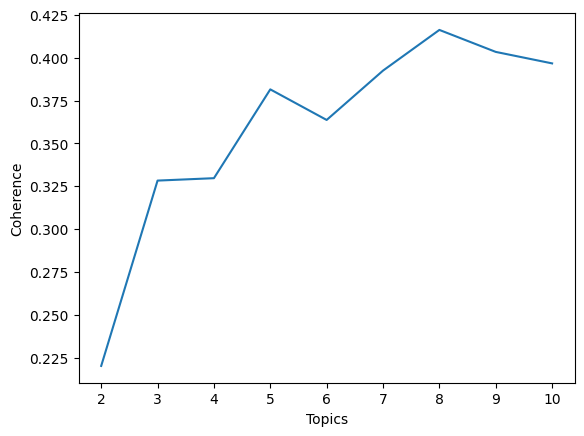

In [38]:
sns.lineplot(x = "Topics", y = "Coherence", data=lda_default)
plt.show()

In [40]:
lda_topic_8 = lda_tuning.loc[lda_tuning['Topics'] == 8].reset_index(drop=True)

In [41]:
lda_topic_8.sort_values(by='Coherence', ascending=False).head()

,Topics,Alpha,Beta,Coherence
17,8,0.9099999999999999,0.61,0.458533
15,8,0.9099999999999999,0.01,0.445715
16,8,0.9099999999999999,0.31,0.439653
18,8,0.9099999999999999,0.9099999999999999,0.433716
19,8,0.9099999999999999,symmetric,0.422574


### Final Result

Parameter 1 -->
Topic: 8
Alpha: 1
Beta: 0.6


Parameter 2 --> 
Topic: 6
Alpha: 1
Beta: symmetric

In [51]:
num_topics = 6

lda_best_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=1.0,
                                           eta='symmetric')

In [46]:
# Compute Coherence Score
coherence_best_model_lda = CoherenceModel(model=lda_best_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_best_lda = coherence_best_model_lda.get_coherence()
print('Coherence Score: ', coherence_best_lda)

Coherence Score:  0.44868948237888523


In [52]:
# Compute Coherence Score
coherence_best_model_lda = CoherenceModel(model=lda_best_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_best_lda = coherence_best_model_lda.get_coherence()
print('Coherence Score: ', coherence_best_lda)

Coherence Score:  0.1373935369698811


In [47]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_best_model.print_topics())
doc_lda = lda_best_model[corpus]

[(0,
  '0.076*"listrik" + 0.074*"pln" + 0.050*"kendaraan" + 0.034*"indonesia" + '
  '0.033*"motor" + 0.033*"electrizen" + 0.023*"ekosistem" + 0.022*"mobile" + '
  '0.020*"mendukung" + 0.018*"loh"'),
 (1,
  '0.080*"ev" + 0.027*"tesla" + 0.018*"air" + 0.015*"harga" + 0.013*"wuling" + '
  '0.008*"china" + 0.008*"batery" + 0.008*"murah" + 0.007*"charging" + '
  '0.007*"mobil"'),
 (2,
  '0.061*"subsidi" + 0.055*"tidak" + 0.026*"mobil" + 0.022*"listrik" + '
  '0.016*"orang" + 0.015*"beli" + 0.011*"rakyat" + 0.009*"kebijakan" + '
  '0.009*"nya" + 0.008*"transportasi"'),
 (3,
  '0.143*"listrik" + 0.140*"mobil" + 0.034*"emisi" + 0.024*"mengurangi" + '
  '0.019*"polusi" + 0.018*"bbm" + 0.018*"hemat" + 0.018*"beralih" + '
  '0.017*"masyarakat" + 0.013*"karbon"'),
 (4,
  '0.053*"baterai" + 0.039*"listrik" + 0.038*"kendaraan" + 0.031*"indonesia" + '
  '0.022*"energi" + 0.021*"ekosistem" + 0.016*"pemerintah" + 0.013*"pertamina" '
  '+ 0.011*"dukung" + 0.011*"nikel"'),
 (5,
  '0.158*"kendaraan" + 0.1

In [50]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_best_model.print_topics())
doc_lda = lda_best_model[corpus]

[(0,
  '0.142*"motor" + 0.125*"listrik" + 0.044*"pln" + 0.039*"rupiah" + '
  '0.032*"juta" + 0.020*"pemerintah" + 0.018*"mobile" + 0.015*"electrizen" + '
  '0.014*"sepeda" + 0.014*"pembelian"'),
 (1,
  '0.072*"ev" + 0.041*"harga" + 0.026*"tesla" + 0.017*"air" + 0.015*"murah" + '
  '0.013*"mobil" + 0.012*"wuling" + 0.008*"china" + 0.008*"wib" + 0.008*"vs"'),
 (2,
  '0.089*"subsidi" + 0.046*"tidak" + 0.034*"mobil" + 0.031*"listrik" + '
  '0.015*"orang" + 0.014*"beli" + 0.011*"rakyat" + 0.010*"kebijakan" + '
  '0.009*"nya" + 0.008*"jalan"'),
 (3,
  '0.136*"listrik" + 0.118*"mobil" + 0.037*"lingkungan" + 0.032*"tidak" + '
  '0.029*"ramah" + 0.028*"emisi" + 0.024*"pakai" + 0.023*"banget" + '
  '0.019*"mengurangi" + 0.016*"polusi"'),
 (4,
  '0.053*"listrik" + 0.051*"kendaraan" + 0.051*"baterai" + 0.042*"indonesia" + '
  '0.037*"ekosistem" + 0.023*"pemerintah" + 0.021*"energi" + 0.017*"mendukung" '
  '+ 0.013*"dukung" + 0.012*"pertamina"'),
 (5,
  '0.165*"kendaraan" + 0.128*"listrik" + 0.049*

In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/ldavis_tuned_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_best_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_tuned_'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.280091  0.093734       1        1  21.311967
0      0.201148  0.103452       2        1  20.858128
2     -0.002957 -0.143144       3        1  20.448964
1      0.061234  0.151314       4        1  19.030281
3      0.020666 -0.205356       5        1  18.350660, topic_info=           Term          Freq         Total Category  logprob  loglift
16        mobil  34672.000000  34672.000000  Default  30.0000  30.0000
4       kendara  16209.000000  16209.000000  Default  29.0000  29.0000
68        motor  15246.000000  15246.000000  Default  28.0000  28.0000
215     baterai   6408.000000   6408.000000  Default  27.0000  27.0000
32    indonesia  10088.000000  10088.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
179       resmi    572.974666   1045.770540   Topic5  -5.5075   1.0938
51        tesla    688.835763   2064.115131   Topic5  -5.3233   0.5981
1284       ribu    506.900397    876.116666   Topic5  -5.6300   1.1483
699        baru    476.637588    767.153828   Topic5  -5.6915   1.2196
32    indonesia    480.197650  10088.136504   Topic5  -5.6841  -1.3494

[292 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1096      1  0.002733  acara
1096      2  0.002733  acara
1096      3  0.002733  acara
1096      4  0.992013  acara
1096      5  0.002733  acara
...     ...       ...    ...
321       1  0.007145    yuk
321       2  0.008574    yuk
321       3  0.001429    yuk
321       4  0.161473    yuk
321       5  0.821653    yuk

[1205 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 3, 2, 4])

## BERTopic

### Testing